In [2]:
import pandas as pd
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
import shap
import pickle
from sklearn.cluster import AgglomerativeClustering
from networkx.algorithms import community
import sklearn_tda as sktda
# Can be downloaded at https://github.com/MathieuCarriere/sklearn-tda
import statmapper as stm
# Can be downloaded at https://github.com/MathieuCarriere/statmapper
from metricmapper import *

In [3]:
directory = 'demo_data/rosenbrock/{}.csv'
X = np.genfromtxt(directory.format('X'),delimiter=',')
exp = np.genfromtxt(directory.format('exp'),delimiter=',')
pred = np.genfromtxt(directory.format('pred'),delimiter=',')

X_sample = np.genfromtxt(directory.format('X_sample'),delimiter=',')
exp_sample = np.genfromtxt(directory.format('exp_sample'),delimiter=',')
pred_sample = np.genfromtxt(directory.format('pred_sample'),delimiter=',')

In [4]:
exp_combine = np.concatenate((exp,exp_sample))
pred_combine = np.concatenate((pred,pred_sample))
X_combine = np.concatenate((X,X_sample))

## Cost-Based Mapper Optimization

In [5]:
#parameter optimization
mapper_cand = []
variance_cand = []
cc_cand = []
param_cand = []
r_cand = [5,10,15,20]
g_cand = [0.1,0.3,0.5]
d_cand = [0.6,0.8,1]

for r in r_cand:
    for g in g_cand:
        for distance in d_cand:
            cover = HypercubeCover(cover_mode="implicit", 
                                   bnds=np.array([[-1.,1]]), 
                                   resolutions=np.array([r]), 
                                   gains=np.array([g]))
            params = {'filters':pred_combine.reshape(-1,1),'colors':pred_combine.reshape(-1,1),'codomain':'vectors','cover':cover,'clustering':AgglomerativeClustering(n_clusters=None, linkage="complete", distance_threshold=distance)}
            M = MetricMapperComplex(**params).fit(exp_combine)
            G = stm.mapper2networkx(M)


            communities_generator = community.girvan_newman(G)
            n_hierarchy = 3
            for n in range(n_hierarchy):
                next_level_communities = next(communities_generator)
            comm = sorted(map(sorted, next_level_communities))

            variance = []
            for bd in comm:
                pts = set()
                if type(bd) == list:
                    for b in bd:
                        pts.update(M.node_info_[b]['indices'])
                else:
                    pts.update(M.node_info_[bd]['indices'])
                pts=np.array(list(pts))
                if len(pts) > 10:
                    variance.append(np.var(pred_combine[pts]))
            mapper_cand.append(M)
            variance_cand.append(np.mean(variance))
            cc_cand.append(nx.number_connected_components(G))
            param_cand.append((r,g,distance))
cost = np.array(variance_cand) / np.max(variance_cand) + np.array(cc_cand)/np.max(cc_cand)
M = mapper_cand[np.argmin(cost)]
param_cand[np.argmin(cost)]

(20, 0.1, 1)

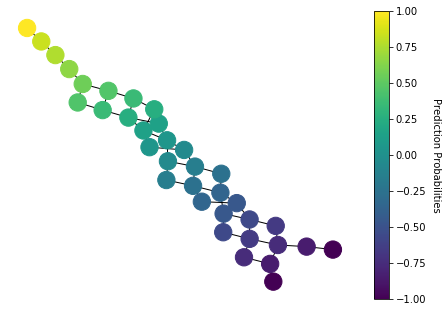

In [6]:
G = stm.mapper2networkx(M)
# G = stm.mapper2networkx(M).subgraph([item for sublist in sbnd for item in sublist])

nx.draw(G, pos=nx.kamada_kawai_layout(G), 
        node_color=[M.node_info_[node]["colors"][0] for node in G.nodes()])

sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=-1, vmax=1))
sm._A = []
cbar = plt.colorbar(sm)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Prediction Probabilities', rotation=270)
plt.show()

## Extract Groups In The Topological Graph

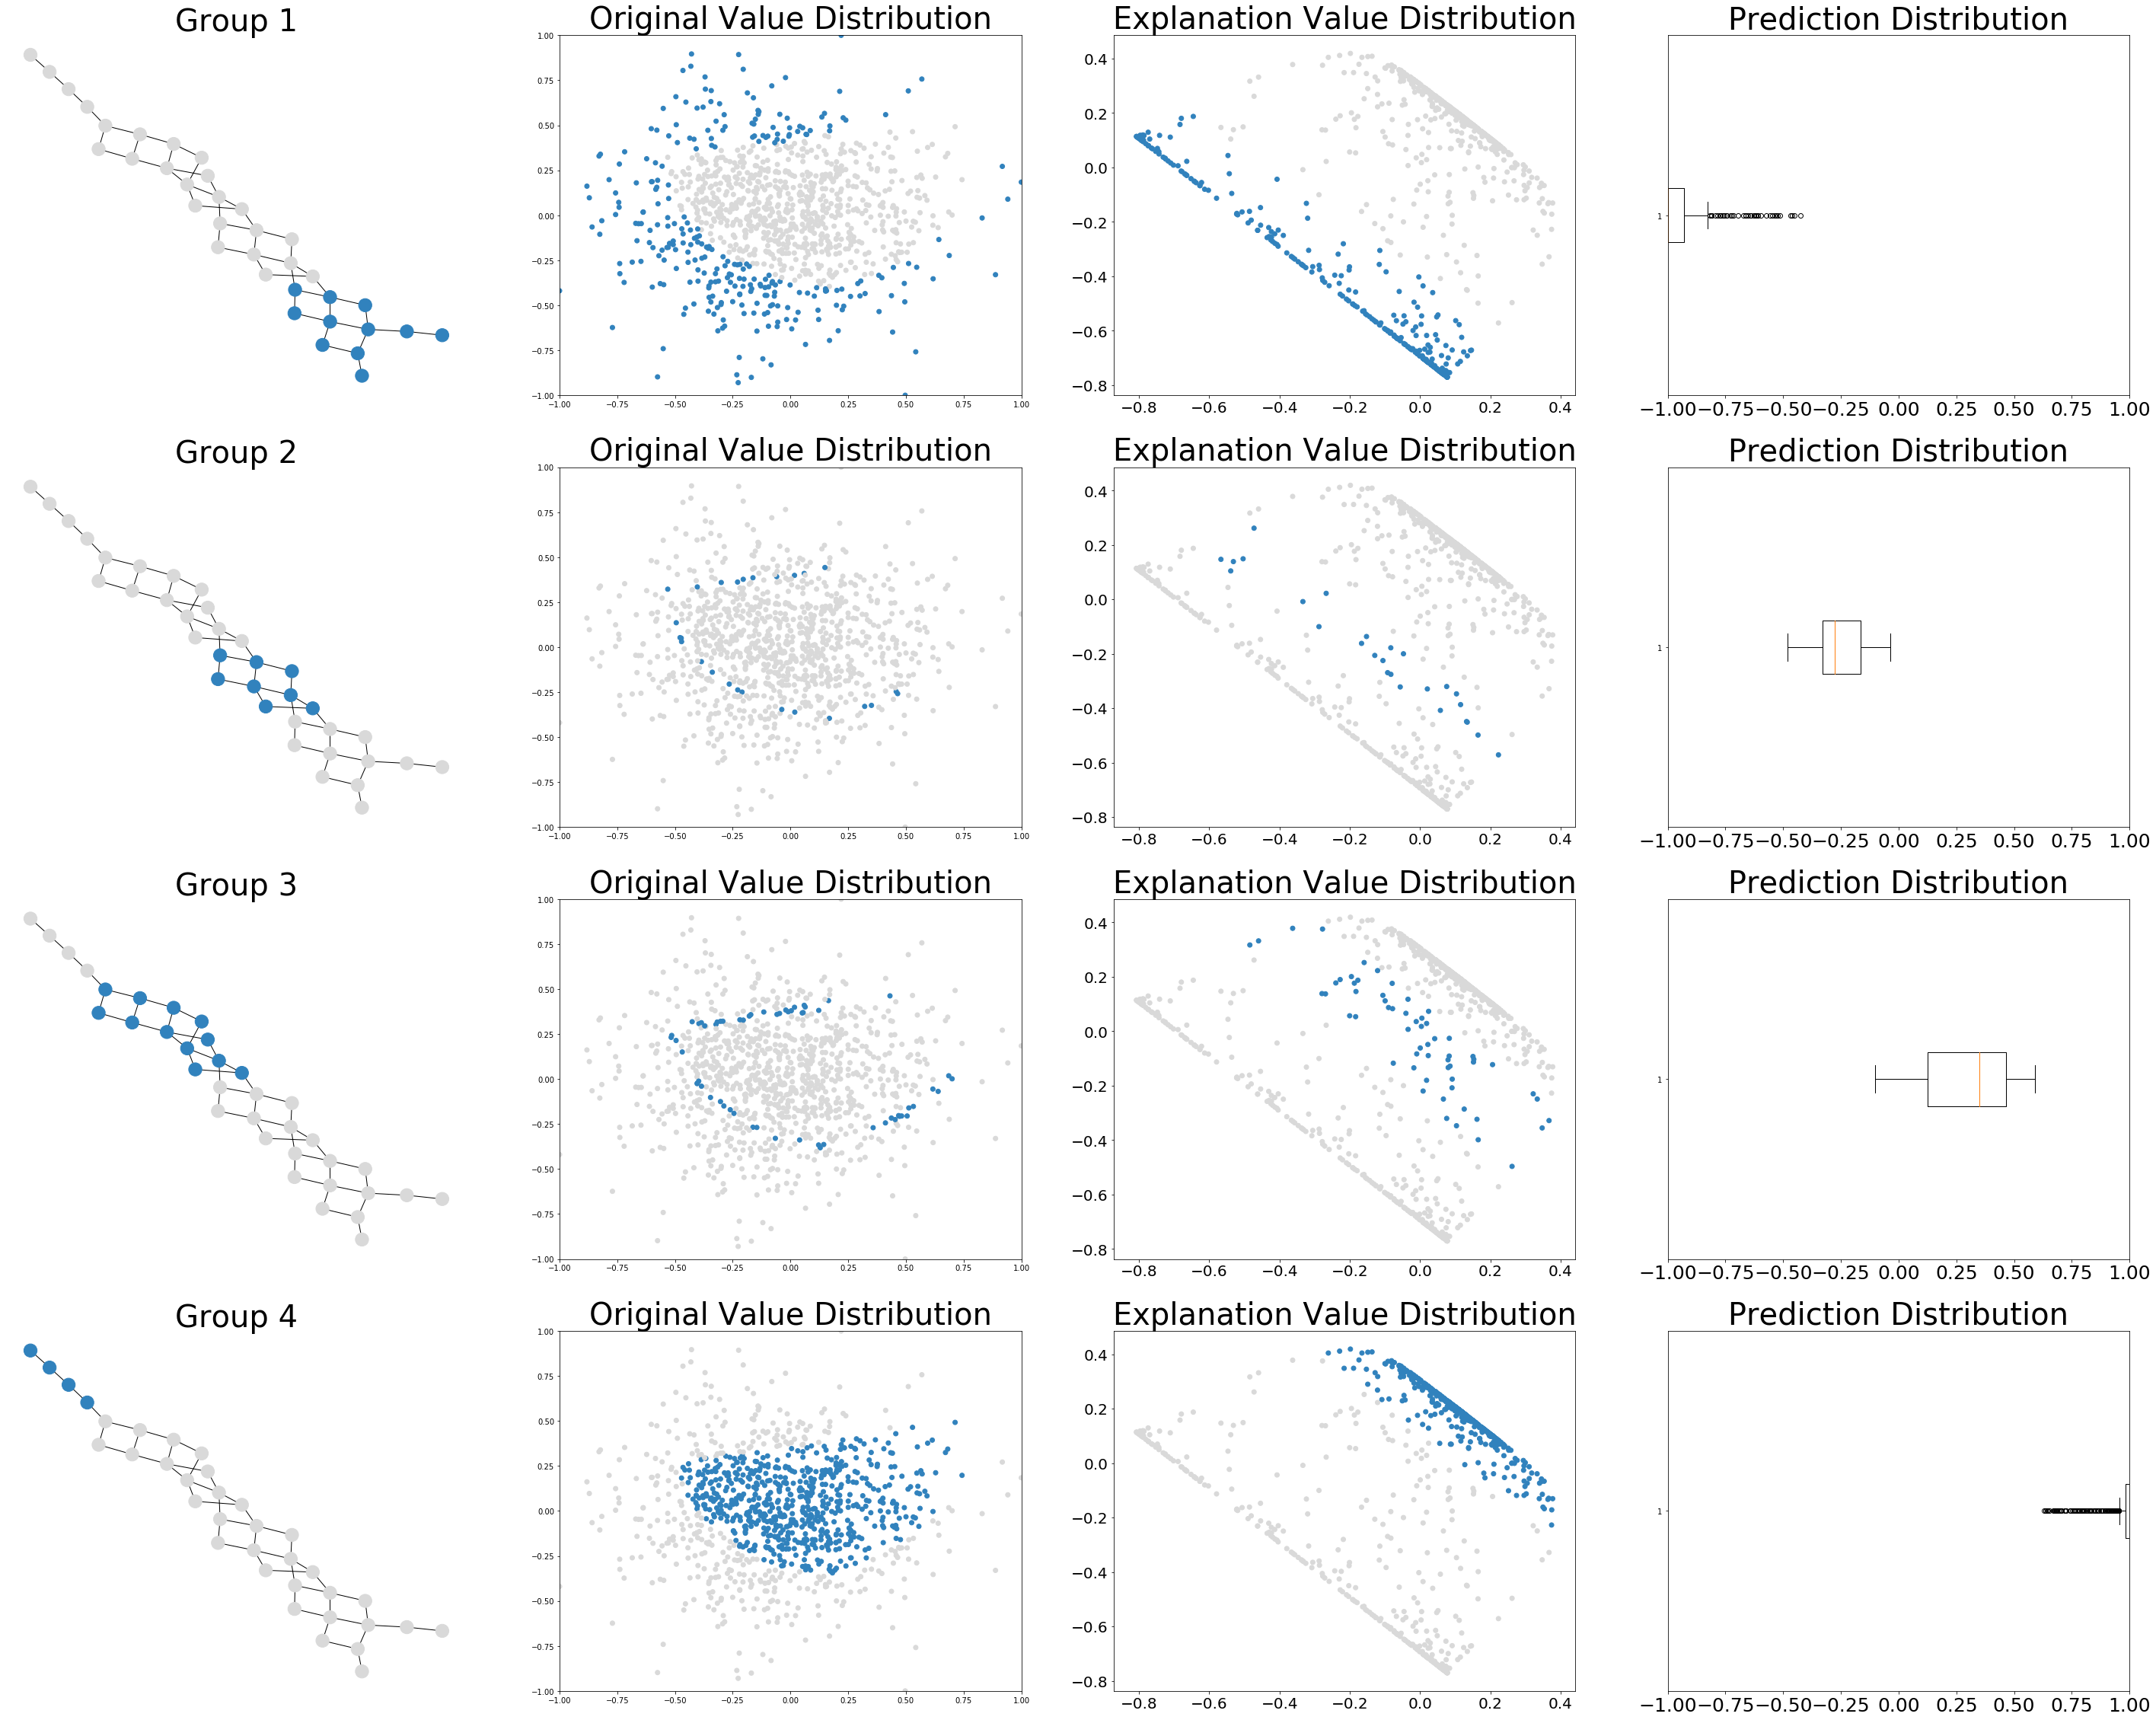

In [7]:
from networkx.algorithms import community
communities_generator = community.girvan_newman(G)
n_hierarchy = 3
for n in range(n_hierarchy):
    next_level_communities = next(communities_generator)
comm = sorted(map(sorted, next_level_communities))

G = stm.mapper2networkx(M)

n_plots = 4
stuff_org = comm
stuff = []
order_by_pred = []
for bd in stuff_org:
    pts = set()
    if type(bd) == list:
        for b in bd:
            pts.update(M.node_info_[b]['indices'])
    else:
        pts.update(M.node_info_[bd]['indices'])
    pts=np.array(list(pts))
    pts = pts[pts<X.shape[0]]
    if len(pts) > 10:
        stuff.append(bd)
        order_by_pred.append(np.mean(pred[pts]))
idx = np.argsort(order_by_pred)
stuff = np.array(stuff,dtype=object)[idx].tolist()

plt.figure(figsize=(50,10*len(stuff)))
for idx, bd in enumerate(stuff):
    plt.subplot(len(stuff),n_plots,idx*n_plots+1)
    plt.title("Group {}".format(idx+1), fontdict = {'fontsize' : 40})
    if type(bd) == list:
        cond = [0 if node in bd else 1 for node in G.nodes()]
    else:
        cond = [0 if node == bd else 1 for node in G.nodes()]
    nx.draw(G, pos=nx.kamada_kawai_layout(G), 
            node_color=cond,cmap='tab20c')
    plt.subplot(len(stuff),n_plots,idx*n_plots+2)
    pts = set()
    if type(bd) == list:
        for b in bd:
            pts.update(M.node_info_[b]['indices'])
    else:
        pts.update(M.node_info_[bd]['indices'])
    pts=np.array(list(pts))
    pts = pts[pts<X.shape[0]]
    c = np.zeros(X.shape[0])
    c[pts] = 1
    c = c.astype(bool)
    
    plt.title("Original Value Distribution", fontdict = {'fontsize' : 40})
    plt.scatter(X[:,0],X[:,1],c=np.abs(1-c),cmap='tab20c')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    
    plt.subplot(len(stuff),n_plots,idx*n_plots+3)
    plt.title("Explanation Value Distribution", fontdict = {'fontsize' : 40})
    plt.scatter(exp[:,0],exp[:,1],c=np.abs(1-c),cmap='tab20c')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    plt.subplot(len(stuff),n_plots,idx*n_plots+4)
    plt.boxplot(pred.flatten()[pts],vert=False)
    plt.xlim((-1,1))
    plt.xticks(fontsize=25)
    plt.title("Prediction Distribution", fontdict = {'fontsize' : 40})
plt.show()